
## Exercise 3 in Data-Oriented Programming Paradigms - Group 42
# On the Evolution of Nuclear Energy Use


Structure:

* Overview of version + modules required to run
* Which questions are we trying to answer
* Datasets, what is in them, why we chose them
* Data processing & exploration
* q1
* q2
* q3
* q4
* conclusions
* discussion on problems with data & biases, tools & techniques learned, work division

Everything should run in this notebook, using the folder structure within this directory


In [3]:
# installing neceessary modules
!pip install pyreadstat
!pip install sklearn

You should consider upgrading via the 'C:\Users\dgiov\OneDrive\Dokumente\Uni\DOPP\DOPP_Exercise3\venv\Scripts\python.exe -m pip install --upgrade pip' command.


  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=e110230ab4afe2fd984eb896c9ce31e07deda2a24fb5df5a420304e7a3ad5d45
  Stored in directory: c:\users\dgiov\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


You should consider upgrading via the 'C:\Users\dgiov\OneDrive\Dokumente\Uni\DOPP\DOPP_Exercise3\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
# imports

import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Data


### Our World in Data - Energy Dataset

Our World in Data is a fantastic resource for datasets of this kind. The data is thoroughly documented, provided in several common formats including simple CSV files, and updated regularly. As such, it is a natural fit to form the backbone of this project. The source data can be found here: https://github.com/owid/energy-data

It should be noted that it is unclear how complete this data is for countries with unreliable reporting, such as China. For the most part however the data seems fairly complete for most major countries of interest in regards to nuclear energy use.

In [5]:
df_energy = pd.read_csv("data/OWID_energy/owid-energy-data.csv")


In [6]:
# further preprocessing as needed by other parts

### Our World in Data - CO2 Dataset
(by Dario Giovannini)

Just as with the Energy dataset, the CO2 dataset is well documented and easy to use. The source data can be found here: https://github.com/owid/co2-data

In [7]:
# dataset is loaded
df_co2 = pd.read_csv("data/OWID_CO2/owid-co2-data.csv")

In [8]:
# A joined dataframe combining the Energy and CO2 datasets is created
relevant_energy = df_energy[["iso_code", "country", "year",
                             "gdp", "population",
                             "primary_energy_consumption", "electricity_generation",
                             "energy_per_gdp", "energy_per_capita",
                             "nuclear_electricity", "nuclear_share_elec",
                             "nuclear_consumption", "nuclear_share_energy"]]
relevant_co2 = df_co2[["iso_code", "country", "year",
                       "population", "gdp", "primary_energy_consumption",
                       "co2", "methane", "total_ghg"]]

joined = relevant_energy.join(
    relevant_co2.set_index(["iso_code", "country", "year"]),
    on = ["iso_code", "country", "year"], rsuffix = "_co2", lsuffix = "_energy"
).set_index(["iso_code", "country", "year"])

In [9]:
# the combined dataframe is investigated, specifically for differences in shared variables & missing values
value_exists = joined[joined["co2"].notna()].groupby(["iso_code", "year"]).count()
(value_exists == 0).sum()

comparevals = ["gdp", "population", "primary_energy_consumption"]
energy_vals = [x+"_energy" for x in comparevals]
co2_vals = [x+"_co2" for x in comparevals]

val_diffs = (joined[energy_vals] - joined[co2_vals].values)[joined["primary_energy_consumption_energy"].notna()]
mean_diff = val_diffs.groupby("country").mean()
max_vals = joined[joined["primary_energy_consumption_energy"].notna()][energy_vals].groupby("country").max() * 100

relative_diff = mean_diff / max_vals.loc[mean_diff.index] * 100
print(relative_diff["gdp_energy"][relative_diff["gdp_energy"].isna()].index)

print(relative_diff["gdp_energy"].dropna().abs().sort_values())

Index(['Africa', 'American Samoa', 'Antigua and Barbuda', 'Aruba',
       'Asia Pacific', 'Bahamas', 'Belize', 'Bermuda', 'Bhutan',
       'British Virgin Islands', 'Brunei', 'CIS', 'Cayman Islands',
       'Central America', 'Cook Islands', 'Czechoslovakia', 'Eastern Africa',
       'Eritrea', 'Europe', 'Europe (other)', 'Faeroe Islands',
       'Falkland Islands ', 'Fiji', 'French Guiana', 'French Polynesia',
       'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guyana',
       'Kiribati', 'Kosovo', 'Macau', 'Maldives', 'Martinique',
       'Middle Africa', 'Middle East', 'Montserrat', 'Nauru',
       'Netherlands Antilles', 'New Caledonia', 'Niue', 'North America',
       'Northern Mariana Islands', 'OPEC', 'Other Asia & Pacific', 'Other CIS',
       'Other Caribbean', 'Other Middle East', 'Other Northern Africa',
       'Other South America', 'Other Southern Africa', 'Papua New Guinea',
       'Reunion', 'Saint Helena', 'Saint Kitts and Nevis',
       'Saint Pierre and

While the values for GDP as well as population differ somewhat between the two datasets, these differences are relatively small. For lack of a better option, the differences will remain unreconciled, and the data from the Energy dataset considered authorative as it also forms the basis for all other considerations in this project.

This combined energy and CO2 dataset will form the basis for specifically the analysis of the CO2 impact of nuclear energy. 

In [10]:
df_co2_and_energy = joined[energy_vals +
            [x for x in relevant_energy.columns if x not in comparevals and x not in joined.index.names] +
            [x for x in relevant_co2.columns if x not in comparevals and x not in joined.index.names]]
df_co2_and_energy.columns = comparevals + list(df_co2_and_energy.columns[3:])

### Integrated Values Survey
(by: Dario Giovannini)

The World Values Survey and European Values Survey are two long-running projects, which each collect similar survey data from across the entire world, and more specifically europe respectively. This data is made available in various formats, but separately as it is aggregated by different institutions. The combination of these two datasets is known the Integrated Values Survey. This dataset was chosen to provide insights into public opinion, specifically regarding nuclear energy, the environment, and trust in public institutions. 

In order to enable users to perform this combination in a consistent manner, a Merge Syntax is provided. Original data, the merge syntax files, and instructions on how to use them can be found here: https://www.worldvaluessurvey.org/WVSEVStrend.jsp

Actually applying this merge syntax turned out to be quite tricky, as I was not familiar with the STATA and SPSS datatypes, but the merge syntax only exists for these. A consirable amount of trial-and-error as well as googling lead me to a proprietary software by IBM that deals with SPSS data, found here: https://www.ibm.com/products/spss-statistics

Luckily, this software exists as a trial version, which was used to successfully apply the merge syntax, creating the integrated values survey datafile. This can be downloaded at the place indicated in the install_data.txt file. 

This data was then explored somwhat, to get a first feel for the overall structure of data and especially missing data:

In [11]:
# IVS is loaded

ivs_data, ivs_meta = pyreadstat.read_sav("data/WVS/Integrated_values_surveys_1981-2021.sav", encoding="cp850")

Text(0.5, 1.0, 'Number of Survey Responses per 5-Year Interval')

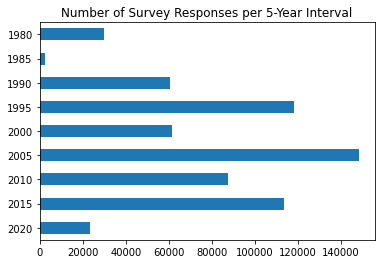

In [12]:
# looking at rough distribution of data in time intervals

(ivs_data["S020"].astype(int)//5 * 5).value_counts().sort_index(ascending=False).plot.barh()
plt.title("Number of Survey Responses per 5-Year Interval")

In [13]:
# country names are converted to ISO-standard 3-letter-codes, which didn't exist in the original data in a unified way

iso_codes = pd.read_csv("data/WVS/iso country codes/iso3166.tsv", sep="\t")
iso_codes["Numeric"] = iso_codes["Numeric"].fillna(0).astype(int)
alpha2_to_alpha3 = iso_codes.set_index("Alpha-2 code")["Alpha-3 code"].to_dict()

def map_codes(alpha2val):
    if alpha2val in alpha2_to_alpha3:
        return alpha2_to_alpha3[alpha2val]
    else:
        return "invalid"

ivs_data["country"] = ivs_data["S009"].apply(map_codes)

# since the 1985 inteval has so few responses, it is combined with the 1980 one.
ivs_data["year"] = (ivs_data["S020"].astype(int)//5 * 5)
ivs_data["year"][ivs_data["year"] == 1985] = 1980

C:\Users\dgiov\AppData\Local\Temp\ipykernel_20152\2580774721.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ivs_data["year"][ivs_data["year"] == 1985] = 1980


In [14]:
responses_per_country_per_interval = ivs_data["country"].groupby(ivs_data["year"]).apply(lambda x: x.value_counts().sort_values()).unstack(level=0).fillna(0).astype(int)

share_of_invalid_responses = responses_per_country_per_interval.loc["invalid"] / responses_per_country_per_interval.iloc[:-1].sum()
print(share_of_invalid_responses)

responses_per_country_per_interval.loc[["AUT", "DEU", "SWE", "FRA", "RUS", "TUR", "CHN", "IND", "JPN", "IRN", "USA", "BRA", "CAN", "MEX"]]

year
1980    0.048422
1990    0.030489
1995    0.037696
2000    0.019819
2005    0.036360
2010    0.000000
2015    0.015988
2020    0.000000
dtype: float64


year,1980,1990,1995,2000,2005,2010,2015,2020
AUT,0,1460,1522,0,1510,0,1644,0
DEU,1305,3437,4062,0,4139,2046,3698,0
SWE,954,1047,2024,0,2190,1206,1194,0
FRA,1200,1002,1615,0,2502,0,1870,0
RUS,0,1961,4540,0,3537,2500,3635,0
TUR,0,1030,1907,4607,3730,1605,2415,0
CHN,0,1000,1500,1000,1991,2300,3036,0
IND,0,2500,2040,2002,2001,4078,0,0
JPN,1204,1011,1054,1362,1096,2443,1353,0
IRN,0,0,0,2532,2667,0,0,1499



the share of responses from unrecognized (as per ISO-3166) countries per time-interval is fairly small, and as might be expected more often found in the older parts of the dataset. Looking at a small sample of potentially interesting countries, none are present in all time-intervals, which indicates potential issues with continuity in the data.

Next, a look is taken at the share of missing data for various questions deemed interesting (Please refer to the EVS_WVS_Dictionary_IVS file for details on these questions beyond the short comment given here):

In [15]:
interesting_questions = ["A001", # family
                         "A002", # friends
                         "A003", # leisure time
                         "A004", # politics
                         "A005", # work
                         "A006", # religion
                         "A010", # happiness
                         "A165", # most people can be trusted
                         "B008", # protecting environment vs econ growth
                         "D059", "D060", # sexism
                         "E069_04", # confidence in press
                         "E069_11", # confidence in government
                         "E069_14", # confidence in environmental protection movement
                         "E235", # importance of democracy
                         "F034", # religious person (maybe redundant with A006)
                         "G006", # proud of nationality
                         ]
# share of non-responses - all these questions have responses on a scale from 1-x, where 0 or negative values are considered non-responses of various descriptions.
by_interval = ivs_data[interesting_questions].applymap(lambda x: x if x > 0 else np.nan).isna().groupby(ivs_data["year"])
non_responses = (by_interval.sum() / by_interval.count().max()).T
non_responses

year,1980,1990,1995,2000,2005,2010,2015,2020
A001,0.200329,0.003055,0.010337,0.009164,0.024444,0.002212,0.001854,0.000418
A002,0.200356,0.003608,0.013270,0.011463,0.026797,0.003554,0.002677,0.000634
A003,0.200525,0.006844,0.019130,0.014700,0.032596,0.006891,0.004599,0.000856
A004,0.200821,0.009076,0.021955,0.019676,0.039319,0.010802,0.008827,0.001591
A005,0.200713,0.005287,0.016999,0.013142,0.035691,0.010169,0.008260,0.001173
A006,0.202777,0.008793,0.023115,0.013291,0.036709,0.008948,0.008065,0.001773
A010,0.137342,0.195198,0.796886,0.416369,1.000000,0.590482,0.766165,0.157605
A165,0.017188,0.021571,0.031261,0.015664,0.058988,0.015907,0.013628,0.001740
B008,0.215932,0.407502,0.351872,0.074760,0.509484,0.043715,0.048044,0.007242
D059,0.215932,0.407502,0.322924,0.052980,0.473132,0.027633,0.024929,0.003790


Most of these questions have fairly high rates of non-responses in the 1980 interval notable exceptions are A165 (general trust) and F034 (religious person). Other questions undergo large fluctuations. Overall, A001-A006, A165, E069_04, F034 and G006 seem like the most reliable values in terms of the share of missing values.

### Global Power Plant Database

The Global Power Plant Database was obtained from https://datasets.wri.org/dataset/globalpowerplantdatabase. It is managed by the World Resources Institute. They have a 100% coverage of nuclear power plants. They get their data from the International Atomic Energy Agency (IAEA). It features the energy capacity, exact location, as well as the commissioning year and also some historcal generation values.

In [16]:
df_power_plants = pd.read_csv("data/PowerPlantDatabase/global_power_plant_database.csv", low_memory=False)
df_power_plants_nuclear = df_power_plants[df_power_plants.primary_fuel.eq('Nuclear')]

## Questions Asked
The original questions on the topic provided the baseline for our investigation into the data. We further refined the questions into these specific forms:


1. How has the use of nuclear energy evolved over time? 
    1. Has the “focus” of nuclear energy shifted in terms of nations or regions heavily employing it?
    1. Are there trends in the types of generators used?
    1. Are there observable impacts of events / disasters (e.g. Chernobyl, Fukushima) on the use of nuclear energy?
1. How well does the use of nuclear energy correlate with changes in carbon emissions? 
1. Are there characteristics of a country that correlate with increases or decreases in the use of nuclear energy?

We chose these questions to gain insights on the evolution of the use of nuclear energy over time as well as regionally and the investigate the impacts it has had as an alternative to fossil fuels in reducing greenhouse gas emissions, specifically CO2. 

### Has the "focus" of nuclear energy shifted in terms of nations or regions heavily employing it?

[ Map ]

### Are there trends in the types of generators used? 
(Daniel May)

We were hoping to find relevant information in the global power plant database. However, the reactor type is not present in this database. The International Atomic Energy Agency (IAEA) manages a database called PRIS (Power Reactor Information System), which contains these information. Sadly, the access to this database is restricted. I actually registered myself for an account, but then you have to specifically request access to this database. Therefore you have to fill in the License Agreement and send to the national authority, which then has to forward this to the IAEA. I've sent the signed License Agreement to our Bundesministerium für Europa, Integration und Äußeres, which is the national authority in charge according to the IAEA, and explained, that we need the data for an university project. However, the BMEIA did not respond to my inquiry.

So sadly this question can not be answered because we were not granted access to the data.


### Are there observable impacts of events / disasters (e.g. Chernobyl, Fukushima) on the use of nuclear energy?
(Daniel May)

We extended this question to also reflect the spirit of countries' population after these events.

So first of all we have to define nuclear accidents.

#### Accidents
The International Atomic Energy Agency (IAEA) defines the International Nuclear and Radiological Event Scale (INES) which can be found at: https://www.iaea.org/sites/default/files/ines.pdf. They define seven levels of nuclear events, where level 1 to 3 are defined as incidents and level 4 to 7 are defined as accidents. We will focus on the more severe accidents with level 5-7. The rating is based on three categories:

- _People and the Environment_: Released radiation dose
- _Radiological Barriers and Control_: Radiation dose released within the installation
- _Defence-in-Depth_: How well the defense measures are working

We are only exploring accidents, that have a direct link to nuclear power plants. There are for example some accidents linked to medical nuclear treatment, which will be excluded on purpose.
The Institute for Energy and Environmental Research (IEER) lists some nuclear reactor accidents on https://ieer.org/resource/factsheets/table-nuclear-reactor-accidents/.

- __7__: Major accident
    - Chernobyl disaster in April 1986 (Soviet Ukraine)
    - Fukushima disaster in March 2011 (Japan)
- __6__: Serious accident
    - Kyshtym disaster in September 1957 (Soviet Russia)
- __5__: Accident with wider consequences
    - First Chalk River accident in December 1952 (Canada)
    - Windscale fire in October 1957 (UK/England)
    - Three Mile Island accident in March 1979 (USA/Pennsylvania)

### Policies
Additionally, we also look into countries' policies on nuclear energy. This is also interesting when analyzing trends, on nuclear power behaviour. Wikipedia (https://en.wikipedia.org/wiki/Nuclear_energy_policy_by_country) lists some interesting policies, where the most important ones are summarized here:

- __Australia__: Nuclear power is forbidden since 1999
- __Austria__: Nuclear reactions are forbidden since 1978
- __Belgium__: planned to phase-out by 2025 in 2018
- __Denmark__: Production is forbidden since 1985
- __Germany__: planned to phase-out by 2022	in 2011
- __Italy__: Did a phase-out in late 1980s, illegal since 2011
- __Serbia__: is restricting nuclear power since 1995
- __Sweden__: has a limit of 10 reactors; only replacing and not building new ones
- __Taiwan__: no new reactors/no life extensions policy since 2016
- __USA__: 13 states have restrictions on nuclear power production

Also Estonia, Greece, Ireland, Latvia, Liechtenstein, Luxembourg, Malta, Portugal, Israel, Malaysia and Norway do not have any nuclear power plants.

Some of these policies could be reactions on nuclear accidents. However, we will explore the development of
- __nuclear power generation__: absolute (amount of nuclear energy) and relative (share of nuclear energy) worldwide and especially for the countries, where the accidents happened
- __values__: Is there a change in certain values of the world's population or a regional trend detectable? In the world value survey, there is one question available about environment vs. economic growth. This could be interesting, because the amount of used energy is a good indicator for the wealth of a population. It would be interesting to see, if people are more likely to make sacrifices in economical growth, since the major nuclear accidents. However, we have to keep in mind that CO2 releasing power plants are also affecting the environment.

We start by looking at the values of the population. Unfortunately, the dataset does not have a very long history, therefore, we can only analyze the impact of the Fukushima Disaster.

The question of interest in this case is only the question "B008", where the possible answers are:
- 1: protecting the environment is more important than economic growth
- 2: economic growth is more important than protecting the environment
- 3: custom answer

We want to exclude the custom answer on purpose because it cannot be evaluated in this context. Missing values are most plausible missing at random, therefore we simply remove those values. We also aggregate by country and year, because this is the granularity we want to look at.

In [17]:
# get rid of answer nr. 3 and NaNs
economic_vs_environment = ivs_data[['country', 'year', 'B008']]
economic_vs_environment = economic_vs_environment[economic_vs_environment.B008.isin([1,2])]
# group by country and year
wvs_agg_world = economic_vs_environment.groupby(['year']).mean()
wvs_agg = economic_vs_environment.groupby(['country','year']).mean()

Let's look at the worldwide development of opinions:

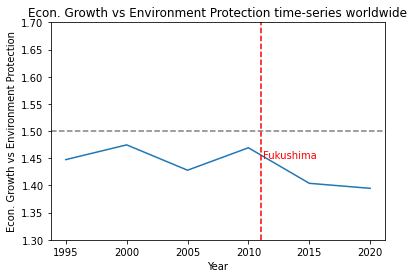

In [18]:
ax = sns.lineplot(x=wvs_agg_world.index, y=wvs_agg_world.B008)
ax.set(ylim=(1.3,1.7))
plt.axvline(x=2011, label="Fukushima Disaster", color="red", linestyle="--")
plt.axhline(y=1.5, label="Baseline", color="grey", linestyle="--")
plt.text(2011.2, 1.45,'Fukushima',c="red")

ax.set_title("Econ. Growth vs Environment Protection time-series worldwide")
ax.set_ylabel("Econ. Growth vs Environment Protection")
ax.set_xlabel("Year");

Now we can observe a scale from 1 = environment first to 2 = economy first. The baseline is marked as a gray line in the plot. We can observe a slight worldwide trend towards environmental protection. Unfortunately, the data to this question is only available starting in 1995. The trend towards environmental protection is stronger since the Fukushima disaster. However, it is not possible to say if the disaster caused this global change of values. We will now further investigate the values of single countries, especially the values of Japan, where the Fukushima disaster happened.
Let's look at Japan:

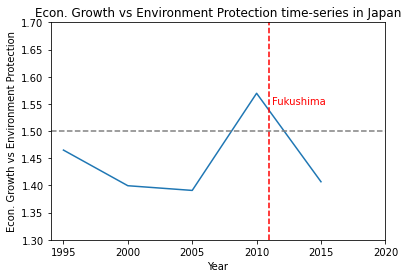

In [19]:
wvs_agg = wvs_agg.reset_index()
# get rid of invalid survey data
wvs_agg = wvs_agg[wvs_agg.country != 'invalid']
ax = sns.lineplot(x=wvs_agg[wvs_agg.country.eq('JPN')].year, y=wvs_agg[wvs_agg.country.eq('JPN')].B008)
ax.set(ylim=(1.3,1.7))
plt.axvline(x=2011, label="Fukushima Disaster", color="red", linestyle="--")
plt.axhline(y=1.5, label="Baseline", color="grey", linestyle="--")
plt.text(2011.2, 1.55,'Fukushima',c="red")

ax.set_xticks([1995,2000,2005,2010, 2015, 2020])
ax.set_title("Econ. Growth vs Environment Protection time-series in Japan")
ax.set_ylabel("Econ. Growth vs Environment Protection")
ax.set_xlabel("Year");

In Japan there was a trend until 2005 to further protect the environment. However, in the year 2010 economical growth seemed to be more important. In 2015 the trend was back on protecting the environment. It is hard to say if the Fukushima disaster had any impact on this trend, but it is safe to say, that there is a stronger trend towards environmental protection since the disaster. Unfortunately the data for 2020 is missing in Japan.

We will now look at a facet plot for observing trends in other nations. Therefore, we will exclude all countries having survey values only in a single year because no trend can be analyzed without two or more data points.

In [20]:
print(len(wvs_agg[wvs_agg.duplicated(subset='country', keep=False)].country.unique()))
wvs_agg = wvs_agg[wvs_agg.duplicated(subset='country', keep=False)]

78


We only take countries into account with 2 or more year measurements. Those are 78 countries. We arrange a facet plot for quickly looking at the different countries.

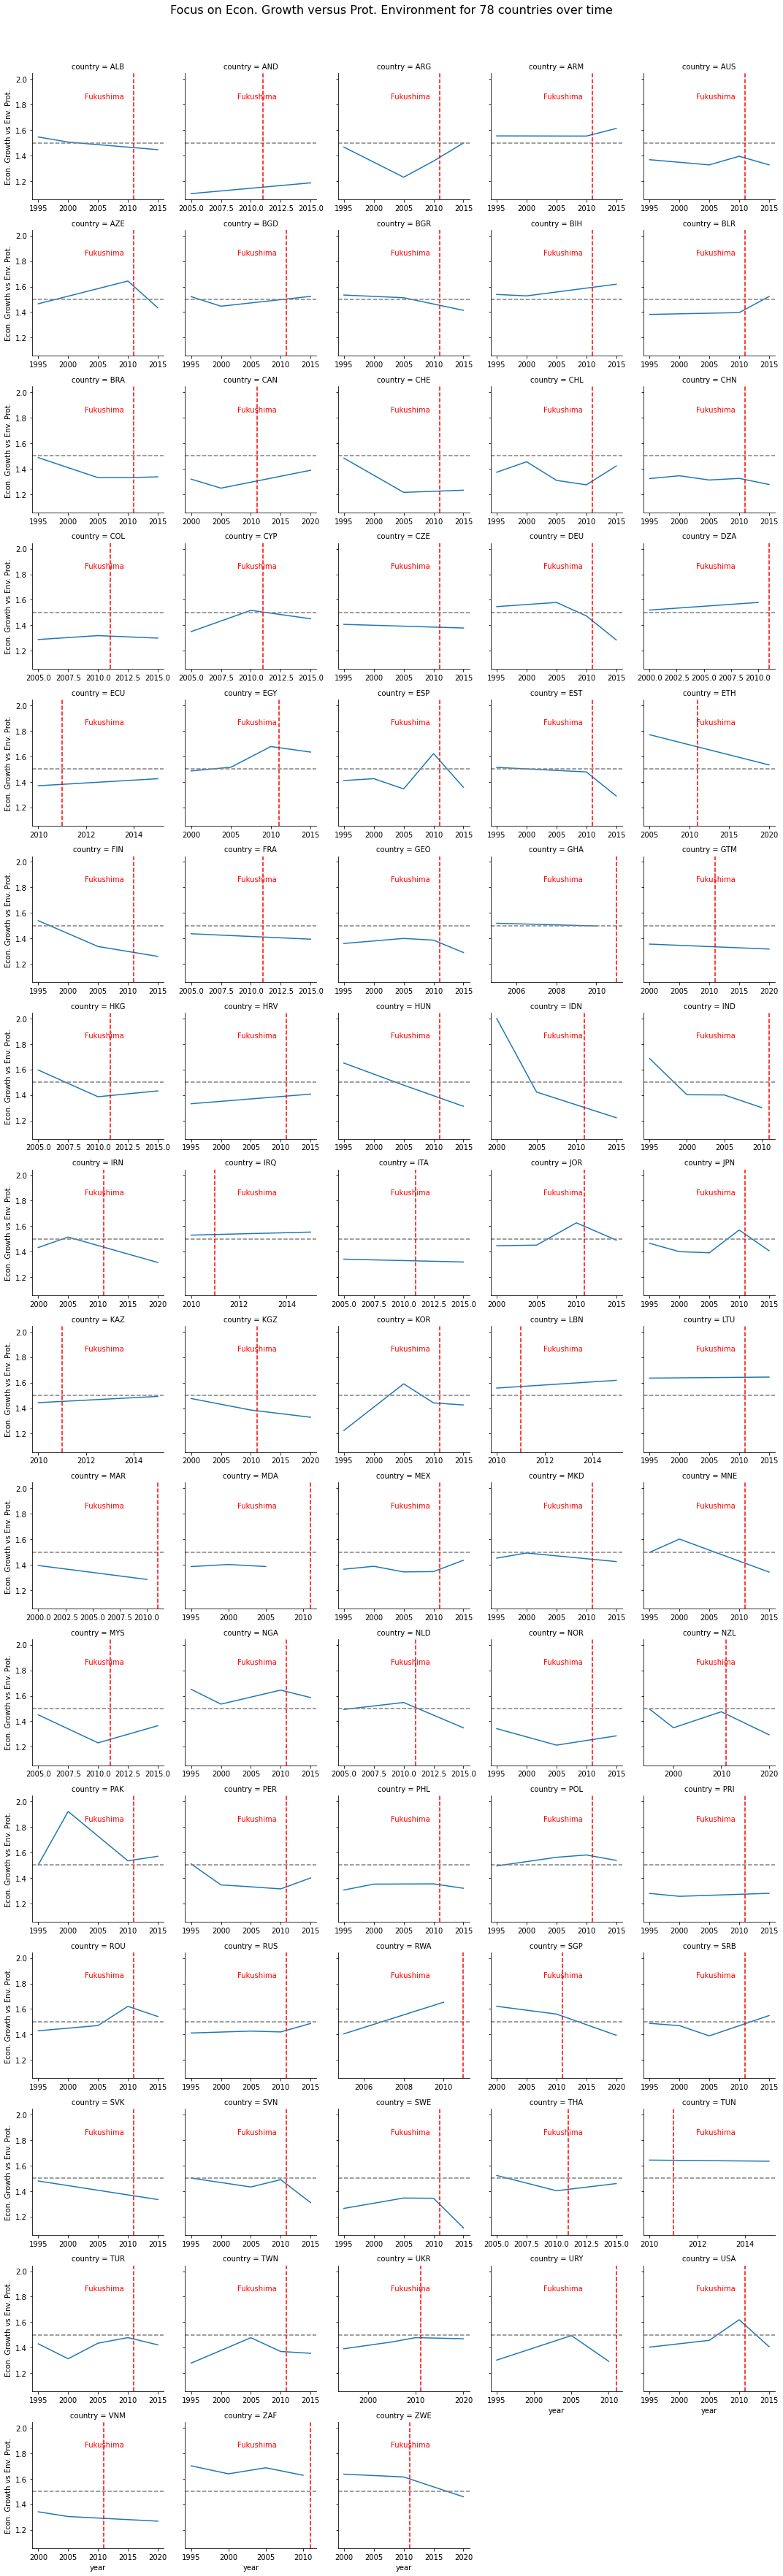

In [21]:
def annotate(data, **kws):
    ax = plt.gca()
    ax.text(.4, .8, "Fukushima", color ="red", transform=ax.transAxes)

g = sns.FacetGrid(wvs_agg, col="country", col_wrap=5, sharex=False)
g.map_dataframe(sns.lineplot, x="year", y="B008")
g.refline(y=1.5, linestyle="dashed", color="grey")
g.refline(x=2011, linestyle="dashed", color="red")
g.map_dataframe(annotate)
g.fig.suptitle('Focus on Econ. Growth versus Prot. Environment for 78 countries over time', size=16, y=1.02)
g.set_ylabels("Econ. Growth vs Env. Prot.");

Germany, Slovenia, USA, Sweden, New Zealand, Georgia, Spain and Estonia have a pretty interesting trend. They all favor ecological aspects much more since the Fukushima Disaster.
Surprisingly, there are some countries, that changed their opinions in favor for economy even after the Fukushima Disaster. Some of them are Armenia, Belarus, Chile and Russia...
However, there are many other countries, where a notable change of trend in favor of protection of the environment can be observed since Fukushima.
These countries are additionally: Australia, Azerbaijan, China, Columbia, Cyprus, Egypt, Jordan, Japan, Nigeria, The Netherlands, Poland, Romania, Singapore, Turkey, Zimbabwe.

Now we will investigate the change of absolute and relative nuclear energy production worldwide and especially for the countries, where the accidents happened. We focus on production, because the producing countries have to deal with the risks of nuclear power plants.

Looking into the dataset description we need two special columns:
- nuclear-electricity = Electricity generation from nuclear power, measured in terawatt-hours
- electricity_generation,“Electricity generation, measured in terawatt-hours”

Here we also assume that the values are missing at random and we exclude missing values from our analysis.

In [22]:
accident_energy = df_energy[['iso_code', 'country', 'year', 'nuclear_electricity', 'electricity_generation']]
# calculating nuclear share of produced energy
accident_energy['nuclear_electricity_share'] = accident_energy['nuclear_electricity'] / accident_energy['electricity_generation']
# dropping non available values
accident_energy = accident_energy.dropna()

C:\Users\dgiov\AppData\Local\Temp\ipykernel_20152\3756901309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_energy['nuclear_electricity_share'] = accident_energy['nuclear_electricity'] / accident_energy['electricity_generation']


In [23]:
# listing the countries that never have produced nuclear electricity
uses_nuclear = accident_energy.groupby('country').sum('nuclear_electricity').nuclear_electricity.gt(0).reset_index()
uses_nuclear[uses_nuclear.nuclear_electricity != True].country

0         Afghanistan
1             Albania
2             Algeria
3      American Samoa
4              Angola
            ...      
203           Vietnam
204    Western Sahara
206             Yemen
207            Zambia
208          Zimbabwe
Name: country, Length: 174, dtype: object

So there are 174 countries that never have used nuclear energy. Let’s focus on the countries that have used nuclear energy.

In [24]:
nuclear_list = uses_nuclear[uses_nuclear.nuclear_electricity].country.tolist()
accident_energy = accident_energy[accident_energy.country.isin(nuclear_list)]
print(nuclear_list)

['Argentina', 'Armenia', 'Belgium', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Czechia', 'Finland', 'France', 'Germany', 'Hungary', 'India', 'Iran', 'Italy', 'Japan', 'Kazakhstan', 'Lithuania', 'Mexico', 'Netherlands', 'Pakistan', 'Romania', 'Russia', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Ukraine', 'United Kingdom', 'United States', 'World']


We will answer this question also by looking at the trends. Let's start with looking at the world data starting in 1985. Therefore the only relevant accidents are Chernobyl in 1986 and Fukushima in 2011.


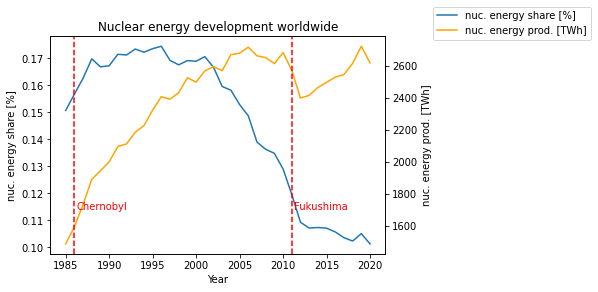

In [25]:
ax = sns.lineplot(x=accident_energy[accident_energy.country.eq('World')].year, y=accident_energy[accident_energy.country.eq('World')].nuclear_electricity_share)
ax2 = ax.twinx()
sns.lineplot(x=accident_energy[accident_energy.country.eq('World')].year, y=accident_energy[accident_energy.country.eq('World')].nuclear_electricity, color="orange")
plt.axvline(x=2011, label="Fukushima Disaster", color="red", linestyle="--")
plt.text(2011.2, 1700,'Fukushima',c="red")
plt.axvline(x=1986, label="Chernobyl Disaster", color="red", linestyle="--")
plt.text(1986.2, 1700,'Chernobyl',c="red")
ax.figure.legend(labels=["nuc. energy share [%]","nuc. energy prod. [TWh]"], loc = 2, bbox_to_anchor = (1,1))

ax.set_title("Nuclear energy development worldwide")
ax.set_ylabel("nuc. energy share [%]")
ax2.set_ylabel("nuc. energy prod. [TWh]")
ax.set_xlabel("Year");

We can clearly see, that the trend of the share of nuclear energy production is declining since 2001. The slope around the Fukushima accident is especially steep. However, it does not appear that the event itself has changed the slope of the line. The absolute amount of nuclear energy however has increased since 2012. Let's look at the data for Ukraine:

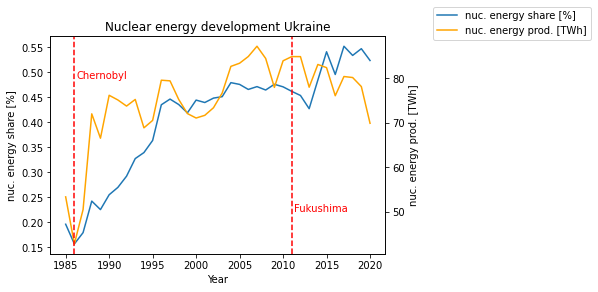

In [26]:
ax = sns.lineplot(x=accident_energy[accident_energy.country.eq('Ukraine')].year, y=accident_energy[accident_energy.country.eq('Ukraine')].nuclear_electricity_share)
ax2 = ax.twinx()
sns.lineplot(x=accident_energy[accident_energy.country.eq('Ukraine')].year, y=accident_energy[accident_energy.country.eq('Ukraine')].nuclear_electricity, color="orange")
plt.axvline(x=2011, label="Fukushima Disaster", color="red", linestyle="--")
plt.text(2011.2, 50,'Fukushima',c="red")
plt.axvline(x=1986, label="Chernobyl Disaster", color="red", linestyle="--")
plt.text(1986.2, 80,'Chernobyl',c="red")
ax.figure.legend(labels=["nuc. energy share [%]","nuc. energy prod. [TWh]"], loc = 2, bbox_to_anchor = (1,1))

ax.set_title("Nuclear energy development Ukraine")
ax.set_ylabel("nuc. energy share [%]")
ax2.set_ylabel("nuc. energy prod. [TWh]")
ax.set_xlabel("Year");

The event of Chernobyl is interestingly at the lowest share of nuclear energy. This could be due to the fact, that this special power plant went out of operation and caused loss of energy production. However, the amount and also the share of nuclear energy went up for many years. After the Fukushima accident there is a decline of amount of nuclear energy. However, the share of nuclear energy seems to rise. Let's also look at Japan.

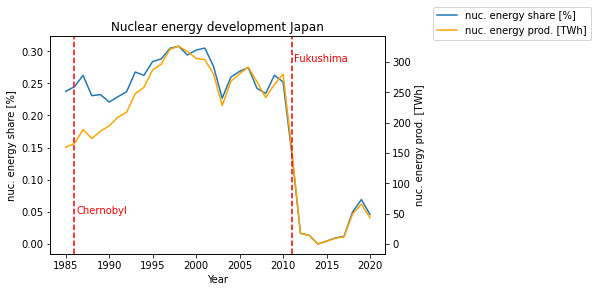

In [27]:
ax = sns.lineplot(x=accident_energy[accident_energy.country.eq('Japan')].year, y=accident_energy[accident_energy.country.eq('Japan')].nuclear_electricity_share)
ax2 = ax.twinx()
sns.lineplot(x=accident_energy[accident_energy.country.eq('Japan')].year, y=accident_energy[accident_energy.country.eq('Japan')].nuclear_electricity, color="orange")
plt.axvline(x=2011, label="Fukushima Disaster", color="red", linestyle="--")
plt.text(2011.2, 300,'Fukushima',c="red")
plt.axvline(x=1986, label="Chernobyl Disaster", color="red", linestyle="--")
plt.text(1986.2, 50,'Chernobyl',c="red")
ax.figure.legend(labels=["nuc. energy share [%]","nuc. energy prod. [TWh]"], loc = 2, bbox_to_anchor = (1,1))

ax.set_title("Nuclear energy development Japan")
ax.set_ylabel("nuc. energy share [%]")
ax2.set_ylabel("nuc. energy prod. [TWh]")
ax.set_xlabel("Year");

There is a rapid decline in share and amount of nuclear energy around the Fukushima Disaster. This could be due to the fact, that this power plant went out of operation. However, the share and amount of nuclear energy has risen recently.

Let's look at a facet plot of the 35 nuclear energy producing countries.

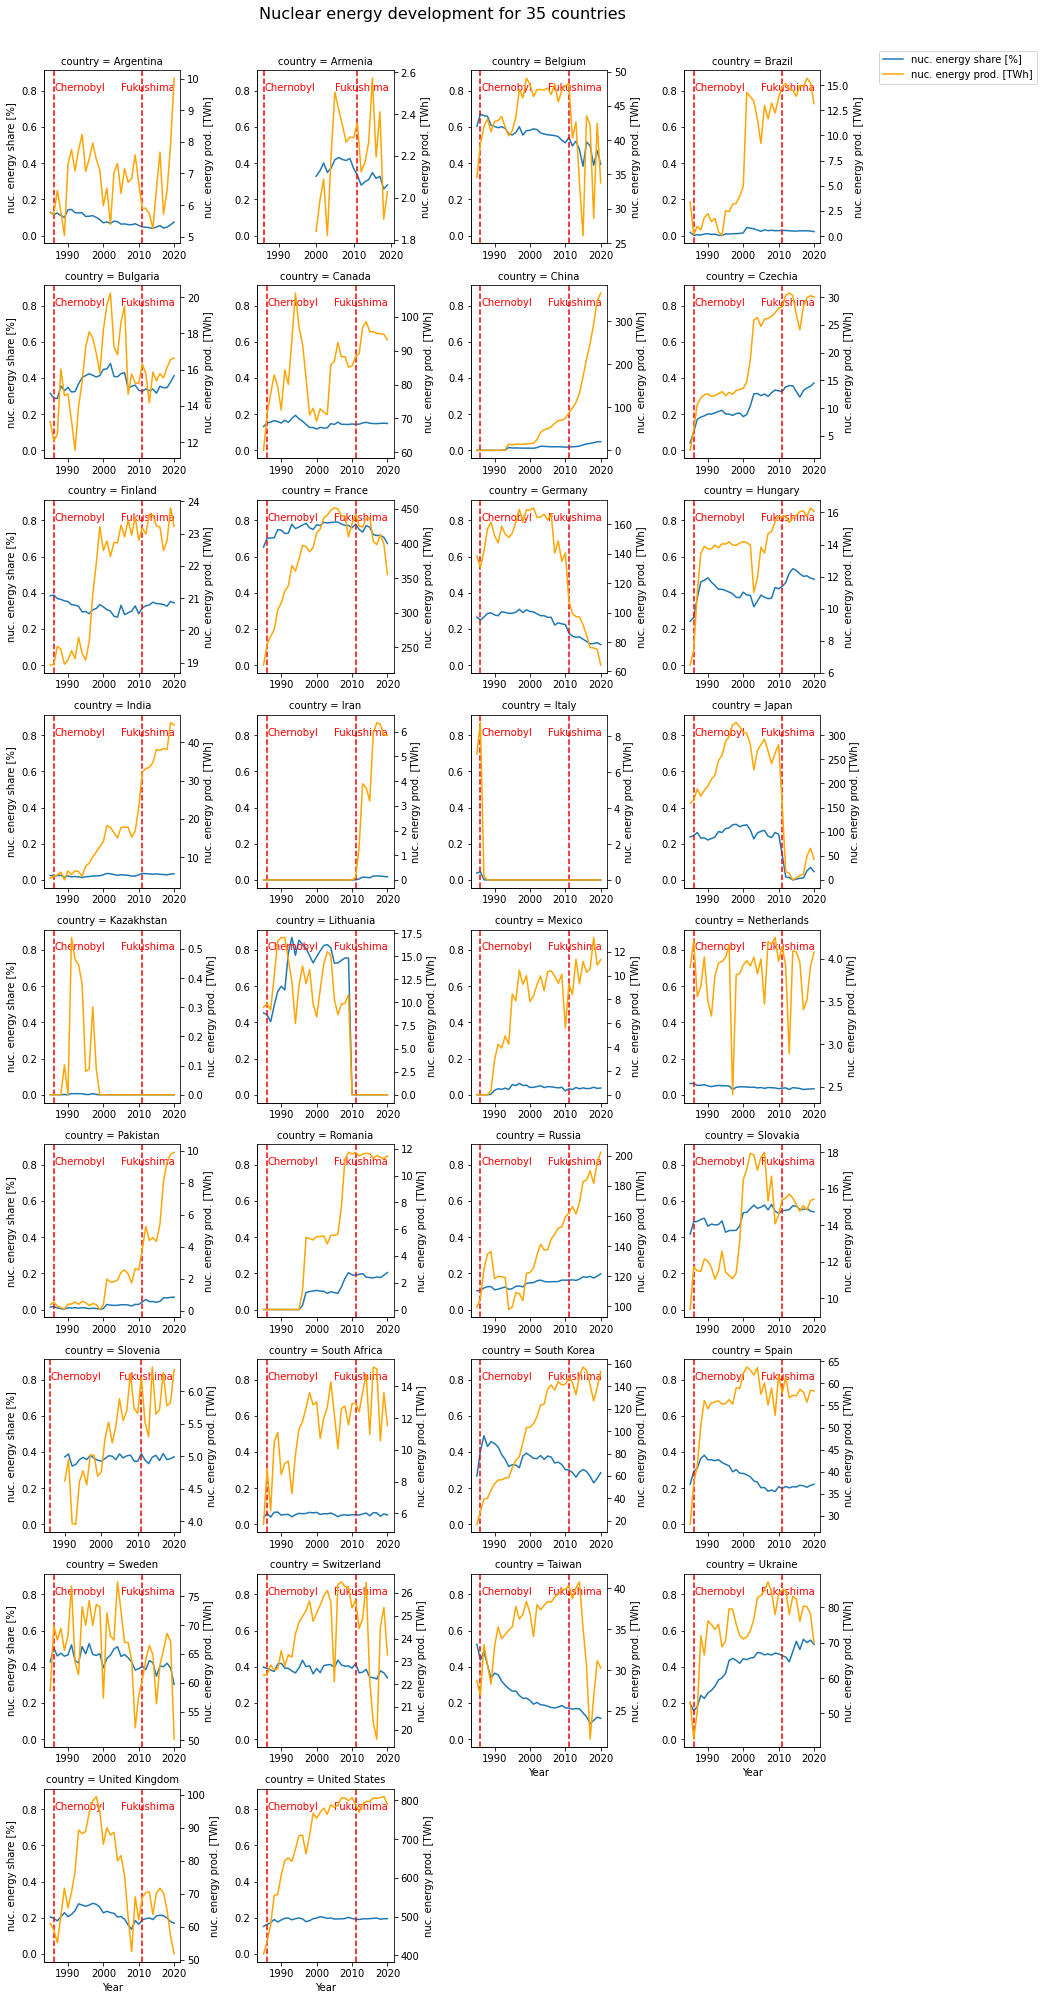

In [28]:
df_energy_without_world = accident_energy[accident_energy.country != 'World']
def facetgrid_two_axes(*args, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.set_ylabel('nuc. energy prod. [TWh]')

    ax.plot(data['year'],data['nuclear_electricity_share'], **kwargs, color=sns.color_palette()[0])

    ax.axvline(x=2011, color="red", linestyle="--")
    ax.text(2005, .8,'Fukushima',c="red")
    ax.axvline(x=1986, color="red", linestyle="--")
    ax.text(1986.2, .8,'Chernobyl',c="red")
    ax2.plot(data['year'],data['nuclear_electricity'], **kwargs, color='orange')

g = sns.FacetGrid(df_energy_without_world, col="country", col_wrap=4,sharex=False, legend_out=False)
(g.map_dataframe(facetgrid_two_axes)
 .set_axis_labels("Year", "nuc. energy share [%]"))
#g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Nuclear energy development for 35 countries', size=16, y=1.02)
legend_patches = [mpl.lines.Line2D([],[],color=sns.color_palette()[0], label="nuc. energy share [%]") ,mpl.lines.Line2D([],[],color="orange", label="nuc. energy prod. [TWh]")]
g.fig.legend(handles=legend_patches, loc = 2, bbox_to_anchor = (1,1))
plt.show()

We can see that Belgium is lowering it's share of nuclear energy, the rate of decline is higher since Fukushima. Also Germany has a decline in nuclear energy share. It also got a bit faster in phasing out since Fukushima. This also matches the policies on phasing out. In Armenia, France, Lithuania, Sweden, South Korea, Taiwan and Switzerland, there can also be a slight decline observed.

To wrap up this question:
There is a noteable decline of share in nuclear energy since 2001. So it declines also after Fukushima, but it does not seem, that this event influenced the speed of trend change. Looking at Ukraine or Japan, we can clearly see a reduction of nuclear energy share at the time of the accident. This is most probably due to loss of the reactors. However, Ukraine and also Japan started to increase their nuclear capacity after their disasters.
Additionally, we can confirm Belgium's and Germany's process of phasing out, with an even faster decline in nuclear energy usage since Fukushima. Armenia, France, Lithuania, Sweden, South Korea, Taiwan and Switzerland are also reducing their nuclear energy share since Fukushima.

### How well does the use of nuclear energy correlate with changes in carbon emissions?
( by Dario Giovannini )

This question will be answered by looking at the yearly difference in CO2 emissions and nuclear energy generation, as well as a look at the overall trend of energy use, per country.

In [29]:
# A dataframe containing all relevant absolute as well as scaled data is created.
# Not all of these values ended up being used, as some turned out to show the same
# thing better, and were thus preferred.

data_carboncorr = df_co2_and_energy[["population", "gdp", "co2", "total_ghg",
           "primary_energy_consumption", "electricity_generation",
           "nuclear_consumption", "nuclear_electricity"]]

data_carboncorr["co2_per_capita"] = df_co2_and_energy["co2"] / df_co2_and_energy["population"] * 1e6
data_carboncorr["co2_per_gdp"] = df_co2_and_energy["co2"] / df_co2_and_energy["gdp"] * 1e6
data_carboncorr["co2_per_kwh"] = df_co2_and_energy["co2"] / df_co2_and_energy["primary_energy_consumption"]
data_carboncorr["total_ghg_per_capita"] = df_co2_and_energy["total_ghg"] / df_co2_and_energy["population"]
data_carboncorr["total_ghg_per_gdp"] = df_co2_and_energy["total_ghg"] / df_co2_and_energy["gdp"]
data_carboncorr["energy_per_capita"] = df_co2_and_energy["primary_energy_consumption"] / df_co2_and_energy["population"]
data_carboncorr["energy_per_gdp"] = df_co2_and_energy["primary_energy_consumption"] / df_co2_and_energy["gdp"]
data_carboncorr["energy_normalized"] = df_co2_and_energy["primary_energy_consumption"] / df_co2_and_energy["primary_energy_consumption"].unstack(level=-1).T.max()
data_carboncorr["electricity_per_capita"] = df_co2_and_energy["electricity_generation"] / df_co2_and_energy["population"]
data_carboncorr["electricity_per_gdp"] = df_co2_and_energy["electricity_generation"] / df_co2_and_energy["gdp"]

data_carboncorr["nuclear_consumption_per_capita"] = df_co2_and_energy["nuclear_consumption"] / df_co2_and_energy["population"]
data_carboncorr["nuclear_consumption_per_gdp"] = df_co2_and_energy["nuclear_consumption"] / df_co2_and_energy["gdp"]
data_carboncorr["nuclear_electricity_per_capita"] = df_co2_and_energy["nuclear_electricity"] / df_co2_and_energy["population"]
data_carboncorr["nuclear_electricity_per_gdp"] = df_co2_and_energy["nuclear_electricity"] / df_co2_and_energy["gdp"]

data_carboncorr["nuclear_energy_share"] = df_co2_and_energy["nuclear_consumption"] / df_co2_and_energy["primary_energy_consumption"]
data_carboncorr["nuclear_energy_share_pct"] = df_co2_and_energy["nuclear_consumption"] / df_co2_and_energy["primary_energy_consumption"] * 100
data_carboncorr["nuclear_electricity_share"] = df_co2_and_energy["nuclear_electricity"] / df_co2_and_energy["electricity_generation"]
data_carboncorr["nuclear_electricity_share_pct"] = df_co2_and_energy["nuclear_electricity"] / df_co2_and_energy["electricity_generation"] * 100

iso_name_dict = {iso:country for iso,country,year in data_carboncorr.index}

C:\Users\dgiov\AppData\Local\Temp\ipykernel_20152\3455039659.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_carboncorr["co2_per_capita"] = df_co2_and_energy["co2"] / df_co2_and_energy["population"] * 1e6
C:\Users\dgiov\AppData\Local\Temp\ipykernel_20152\3455039659.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_carboncorr["co2_per_gdp"] = df_co2_and_energy["co2"] / df_co2_and_energy["gdp"] * 1e6
C:\Users\dgiov\AppData\Local\Temp\ipykernel_20152\3455039659.py:11: SettingWithCopyWarning: 


The most useful of these values turned out to be the CO2 per kWh metric, which refers to tons of CO2 (in the original data, the CO2 column is in Million Tons, and the primary energy use in Terawatthours - this cancels out to kg CO2 per kWh, which is a great metric to show the overall "dirtyness" of the energy used.

Another value worth explaining is the "normalized" energy, which is simply the primary energy consumption divided by its maximum value in the data. This brings the energy use to a scale of 0 to 1, which makes it easily comparable with other ratio data such as the nuclear energy share.

#### Nuclear Energy "Leaderboard"
The first step in this analysis was to figure out which countries even use nuclear energy. To do this, an aggregate dataframe was created containing information such as the total energy from nuclear sources per country, as well as the share of total energy consumption from nuclear sources. It should  be noted here that in general this analysis considered the total energy consumption rather than electricity, as this presents a more complete picture of the environmental impacts of energy use. 

In [30]:
nuclear_countries = data_carboncorr[data_carboncorr["nuclear_consumption"] > 0].groupby(["iso_code", "country"]).any().index
nuclear_country_info = pd.DataFrame(index=nuclear_countries)
total_nuclear_energy = data_carboncorr["nuclear_consumption"].reset_index().groupby(["iso_code","country"]).sum().drop("year", axis=1)
nuclear_country_info["total_nuclear_energy"] = total_nuclear_energy.loc[nuclear_country_info.index]
total_energy = data_carboncorr["primary_energy_consumption"].reset_index().groupby(["iso_code","country"]).sum().drop("year", axis=1)
nuclear_country_info["total_energy"] = total_energy.loc[nuclear_country_info.index]
nuclear_country_info["lifetime_nuclear_share"] = nuclear_country_info["total_nuclear_energy"] / nuclear_country_info["total_energy"]

nuclear_country_info.sort_values(by="lifetime_nuclear_share")

,,total_nuclear_energy,total_energy,lifetime_nuclear_share
iso_code,country,,,
KAZ,Kazakhstan,6.913,23264.028,0.000297
IRN,Iran,101.331,68665.291,0.001476
ITA,Italy,249.701,96912.559,0.002577
CHN,China,5963.849,742644.728,0.008031
BRA,Brazil,805.832,97896.846,0.008231
NLD,Netherlands,479.724,49581.065,0.009676
IND,India,1762.044,182071.683,0.009678
MEX,Mexico,715.345,71764.386,0.009968
PAK,Pakistan,228.372,22064.271,0.010350


Perhaps unsurprisingly, France turns out to be the country with the overall largest share of energy use from nuclear sources. Lithuania came as a surprise to me in featuring so high on this list, but the reason for this shall become apparent later. 

#### Correlation in Nuclear Energy Use Change and CO2 Emission Change

The core of this question is investigating a potential correlation between a country's CO2 emissions and their use of nuclear energy. This is done by primarily looking at the yearly difference in the share of a country's energy that is produced by nuclear sources, and the change in the CO2 per kWh metric, which measures the "dirtyness" of the country's energy - that is, how much CO2 (in kilos) is produced per kWh of primary energy use from all sources.

Incidentially, while only one of these values is a ratio and thus expected to be in the range from 0 to 1, the CO2 per kWh metric also shares a similar range, making the comparison convenient to visualize.

<AxesSubplot:ylabel='iso_code,country'>

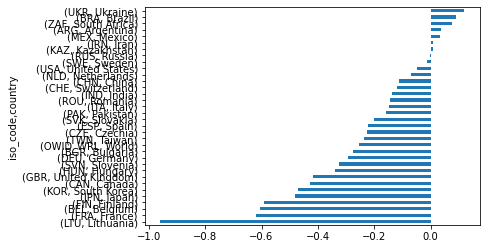

In [31]:
# A small helper function extracts the correlation between the two target values.
def get_corr(df):
    df.columns = df.columns.get_level_values(0)
    c = df.corr()
    return c.iloc[0,1]

yearly_change = data_carboncorr.unstack(level=[0,1]).diff()[["nuclear_energy_share", "co2_per_kwh"]]
yearly_change_corr = yearly_change.groupby(level=[1,2], axis=1).apply(get_corr).dropna()
yearly_change_corr.sort_values().plot.barh()

This plot shows that for most countries that use any amount of nuclear energy, the correlation between the share of nuclear energy and the CO2 per kWh metric is negative, meaning that as nuclear energy share increases, the amount of CO2 per kWh can be expected to decrease. This matches well with expecations, given that nuclear energy is not from fossil fuels and has no carbon emissions at all in operation, although building the powerplants is of course a significant efforts, and issues around storing the nuclear waste are not considered at all here. 

The correlation, while technically "there", is for the most part not very strong, with only a few countreis reaching values of even +/- 0.4. This indicates that there are other effects at play as well, presumably a general increase in efficiency of fossil fuel-based power plants, as well as the general rise of renewable energies such as solar and wind. 

Very notably, Lithuania has a very high negative correlation evident from this yearly change data. To investigate this and some other interesting cases, some individual countries are looked at in more detail.

In [52]:
# A convenient function for quickly plotting a single country's trajectory through the years.
def make_country_plots(iso):
    d = data_carboncorr.loc[(iso, iso_name_dict[iso])]
    fig1 = d[["co2_per_kwh", "nuclear_energy_share", "energy_normalized"]].plot()
    ax = plt.gcf().axes[0]
    ax.set_ylabel("Ratio")
    secax = ax.secondary_yaxis("right")
    secax.set_ylabel("kg CO2 per kWh")
    plt.title("Nuclear Share & CO2 development in "+iso_name_dict[iso])
    fig2 = d.diff().plot.scatter("co2_per_kwh", "nuclear_energy_share")
    plt.title("Scatterplot for yearly change in "+iso_name_dict[iso])
    plt.show()

C:\Users\dgiov\AppData\Local\Temp\ipykernel_20152\204653930.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = data_carboncorr.loc[(iso, iso_name_dict[iso])]


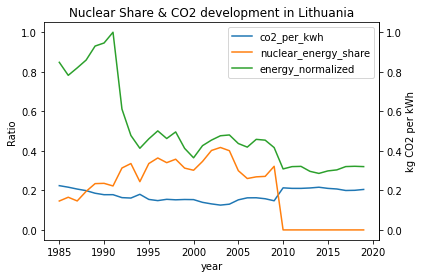

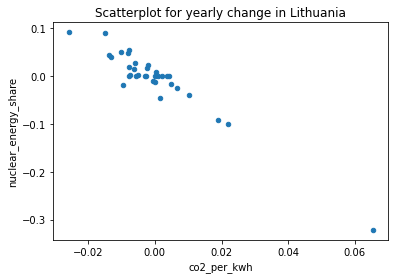

In [53]:
# case study: Lithuania
make_country_plots("LTU")

As it turns out, Lithuania shut down their last nuclear reactors in 2004 and 2009. This is clearly visible in this plot through the drop in nuclear energy share in those years, very clearly in 2009 when it drops to 0. At the same time this coincides with a significant rise in the CO2 per kWh metric, showing that the energy that had previously come from nuclear sources was most likely made up for by energy from fossil sources, which of course emit significant amounts of CO2. As a result, the correlation - as can be seen from the initial results as well as the scatter plot shown here - is a very strong one, and even without the outlier year of 2009 would be significant.

Another interesting feature of this country's development is the large drop in energy use around 1991. This coincides with the dissolution of the Soviet Union, and is likely not a coincidence and very interesting, but further investigation of this effect is outside the scope of this project.

In [ ]:
# case study: France
make_country_plots("FRA")

France, being the overall leader in nuclear energy share worldwide, is an obvious candidate for further examination. They also show the second-best correlation, although only barely over -0.6 and thus not very significant. Nonetheless, studying these plots tells a compelling story - the massive expansion in nuclear energy use in the 1980s was accompanied by a significant reduction in CO2 emissions per kWh used. Subsequent stagnation in nuclear energy share lead to a similar stagnation in energy "dirtyness", although it is still slightly decreasing - likely due to aforementioned factors of increased efficiency of power plants and the general spread of renewable energies.

In [ ]:
# case study: Ukraine
make_country_plots("UKR")

Ukraine is an interesting case in that it is an example of a positive correlation, which is counter to the intuitive expectation. This correlation is very weak and thus shouldn't be considered significant, but still bears investigation.

The first plot shows a similarly steep decline in overall energy use as Lithuania, which again is likely connected to the dissolution of the Soviet Union. Overall while the share of nuclear energy is trending upwards in time, the CO2 per kWh metric also trends upwards, which leads to the observed slightly positive correlation. The explanation is likely that the upwards trending nuclear energy share is more due to decreased overall energy consumption rather than expansion of nuclear energy use however.

In [ ]:
# case study: Germany
make_country_plots("DEU")

An interesting country to look at simply due to geographical and cultural proximity to Austria (which of course does not have nuclear energy itself [except what might be imported, which is difficult to track]), is Germany. They have an overall weak correlation between nuclear energy share and CO2 per kWh, which is partially explained by their overall low nuclear energy share, but more significantly by the reduction in nuclear energy use starting in the mid-2000s, which is accompanied by not an increase in CO2 per kWh, but a further steady decline, accelerating in recent years. This is likely to a comparably large expansion of renewable energy, as well as potentially more efficient fossil fuel-based powerplants. 

In [ ]:
# case study: USA
make_country_plots("USA")

A slow increase in nuclear energy share corresponds to an almost constant kg CO2 per kWh value. Simultaneously, the slight decline in energy "dirtyness" in the 2010s corresponds to a roughly constant nuclear energy share. Thus, there is very little correlation to be found here, and reductions in CO2 per kWh cannot solely be attributed to nuclear energy.

In [ ]:
# case study: Japan
make_country_plots(("JPN"))

Immediately obvious is the large drop in nuclear energy share after 2010, which is almost certainly due to the Fukushima disaster following a tsunami in March 2011. Japan has a comparably strong correlation between nuclear energy share and CO2 per kWh, although still weak with a value of ~ -0.4. Following the drop in nuclear energy share, it is now increasing again, accompanied by a renewed reduction in co2 per kWh. Very likely this is due to short-term solutions to make up for missing energy from nuclear sources being phased out in favour of renewable energies, as well as new nuclear sources as public fear and scepticism wanes.

In [ ]:
# case study: World
make_country_plots("OWID_WRL")

As the final "case study", a look was taken at the overall data for the entire world. Given that only a few countries use nuclear energy to a significant degree, the overall low share of nuclear energy use is expected. Overall, no significant correlation can be detected from this data, but it is quite interesting to see the rather steep increase in worldwide energy use, especially when compared to the graphs for the same value for some of the countries looked at here, many of which are showing a decrease in total energy use in recent years, which indicates a shift in where growth happens worldwide.

#### Conclusions for Correlation between Nuclear Energy Use and CO2 Emissions

As has been shown, different countries show very different profiles in regards to this question. Overall, a slight trend can be observed that widespread use of nuclear energy (which is to say, the country has a high nuclear energy share) is accompanied by a reduction in CO2 emissions per kWh energy used in total. This trend hold especially strongly for cases where there is a rapid decline in nuclear energy use - such as in the cases of Lithuania and Japan - when carbon-based fossil fuels are used as immediately available replacements. For countries such as France, for which nuclear energy constitutes a large portion of their overall energy use, this correlation can also be observed in the stages of expansion of nuclear energy. For most countries however neither extreme holds, and thus no statistically significant correlation can be identified.

## Are there characteristics of a country that correlate with increases or decreases in the use of nuclear energy?

(by Philip Vonderlind)

This part will be used to document the exploration of the question:

_"Are there characteristics of a country that correlate with increases or decreases in
the use of nuclear energy?"_

In order to gather information about this topic, we are going to use the "World Values Survey" (WVS).
It is a dataset that records various psychological effects and phenomena of citizen from various countries.
The data in the WVS is collected from the World Value Study and the European Value Study. Hence, some
questions/features included in the dataset are not available for certain countries.
Data is collected in 5-Year intervals. This is important to know, as merging the data on years with other
datasets will require some tweaking of the granularity of the time data (5-year versus 1-year etc.).

For the nuclear energy part, we are going to rely on the "Our World in Data - Energy" (OWID) dataset. We
also use this dataset for a few other questions we try to answer. It contains yearly information about
various energy features, including nuclear, renewable, coal and many more. We are going to focus solely
on the nuclear energy related features to research this question.

### Pre-Processing for WVS

As the dataset is very huge and has a lot of features, we will only be able
to analyse a select few that we deemed appropriate with our limited time.
The features from the WVS that in our opinion could influence the usage
of nuclear energy are (not limited to) the following:

In [ ]:
relevant_nuclear_features = [
                             'E105', #Aproval of Anti-Nuclear Movement
                             'E069_11', #Confidence in the Government
                             'E069_03', #Confidence Education System
                             'E001', #Aims of country first choice
                             'E022', #Opinion about scientific advances
                             'E016', #Future changes: More emphasis on technology
                             'B008', #Protecting Env. vs Economic Growth
                             'B007', #Protecting Env and fighting pollution is less urgent
                             'B005', #All talk about the environment make people anxious
                             'B003', #Government should reduce environmental pollution
                             'A071B', #Member: Belong to conservation, the environment, ecology
                             ]

As the data in the WVS is a questionare format, it is a good idea to first pre-process them via the codes
and throw out any answer we can not use for our analysis (non-answer, other than listed answer, etc.)

### Handling missing data

We will see that the data has lots and lots of missing values, due to people not being asked certain questions
anymore depending on year and/or country.

In [ ]:
wvs_interesting = ivs_data.loc[:, relevant_nuclear_features + ['country', 'year']]
missing_by_interval = ivs_data[relevant_nuclear_features].applymap(lambda x: x if x > 0 else np.nan).isna().groupby(ivs_data.year)
non_responses = (missing_by_interval.sum() / missing_by_interval.count().max()).T
miss_ax = sns.heatmap(non_responses, annot=True, vmin=0, vmax=1)
miss_ax.set_title("Fraction of missing data in each feature for WVS");

We can see that some features mainly consist of missing values.
For the features affected, it is probably best to exclude them from this analysis, as imputation would
introduce gigantic bias. Most of the missing data can be attributed to the questions just not being asked (or are
answered for that matter). This is unfortunate, as some of them would be interesting to analyse,
such as E105. The same goes for B003, B007, B069_03 and A071B.

For other columns the missing data is manageable, but also can be attributed to the same issues.

Since they are very interesting and may be very relevant for the analysis.
For the columns with large numbers of NAs, we will drop them:

In [ ]:
wvs_cleaned = wvs_interesting.loc[:, ~wvs_interesting.columns.isin(["B005","B003","B007","A071B","E105","E069_03"])]

There is also a country 'invalid' that we have to remove:

In [ ]:
wvs_cleaned = wvs_cleaned.loc[~(wvs_cleaned.reset_index().country == 'invalid').values, :]

In order to get a better overview of the data over the timeframes, we will just take the
averages of the columns. Since most of them are codes ordered from ae. 1-4 for good-bad government,
it makes sense to do so.

In [ ]:
wvs_clean_agg = wvs_cleaned.groupby(['country','year']).mean()
wvs_clean_agg

We still get a few NAs, for them will just use imputation, as for most
countries there are not that many NaNs per feature.

In [ ]:
wvs_clean_agg = wvs_clean_agg.fillna(wvs_clean_agg.interpolate())

## Overview of the chosen features

In order to better understand what the features we have chosen actually represent,
we will create a few plots that aim to give a brief overview. This may also be used
again in later steps to show relationships to nuclear energy features.

### Economic Growth versus Protecting the Environment



In [ ]:
comp_countries = ['JPN','DEU','USA','FRA']
nuc_comp = wvs_clean_agg.reset_index()
nuc_comp = nuc_comp.loc[nuc_comp.country.isin(comp_countries),:]
g = sns.FacetGrid(nuc_comp, col="country", col_wrap=2)
g.map_dataframe(sns.lineplot, x="year",y="B008")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Responses of B008 for interesting countries');

We can see that for most countries, the trend goes towards more economic orientation, expect for
Germany. The experience a steep drop to protecting the environment (closer to 1) after 2005. There
may some interesting phenomena at this point in time.

For the other countries, we only see a drop for Japan after the reactor accident in Fukushima (2011)
occurred.

There are certain Movements like 'Atomkraft:Nein' that were/are very prominent in german speaking countries. This may have an effect on this orientation.
To further analyse this, we could also look at the values over time to get insight when/if something changes at some point.

In [ ]:
ax = sns.lineplot(x=nuc_comp.year, y=nuc_comp.loc[nuc_comp.country == 'DEU','B008'])

plt.axvline(x=2011, label="Fukushima Disaster", color="red", linestyle="--")
plt.text(2011.2, 1.74,'Fukushima',c="red")

plt.axvline(x=2005, label="Nuclear Phasing Out", color="green", linestyle="--")
plt.text(1998, 1.6,'Nuclear Phasing Out',c="green")

ax.set_title("Econ. Growth vs Environment Protection time-series for Germany")
ax.set_ylabel("Econ. Growth vs Environment Protection")
ax.set_xlabel("Year");

We can see a pretty clear trend down towards 'Protecting environment'.
Interestingly, this change starts at around 2005. If we research the year 2005, this is the start of the 'phasing-out' phase for nuclear energy.

This was initiated by the German Green Party, which is heavily anti-nuclear energy. For reference, see this BBC article from back then: http://news.bbc.co.uk/1/hi/world/europe/4295389.stm

### Opinion about scientific advances

Below, we repeat the same faceted plot for the feature E022 (Opinion about scientific advances).
Similar to the last plot, we see a change of trend for germany after 2005. A higher score means
that the countries general reaction to scientific advances is negative. The population thinks
the advances will cause more harm than good in the long run.

For the other countries that heavily rely on nuclear energy, we see the opposite. They all trend
towards a lower score. Japan is rather high to begin with, which is due to them probably voting
more in the category 3 "Some of each". Nevertheless, the trend goes down in the long run.

In [ ]:
g = sns.FacetGrid(nuc_comp, col="country", col_wrap=2)
g.map_dataframe(sns.lineplot, x="year",y="E022")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Responses of E022 for interesting countries');

### Aims of country: First choice

In [ ]:
wvs_e001_plot = wvs_cleaned.reset_index()
wvs_e001_plot = pd.get_dummies(wvs_e001_plot.loc[wvs_e001_plot.country.isin(comp_countries),["E001","country","year"]], columns=["E022"]).groupby(["country","year"]).sum()
wvs_e001_plot = wvs_e001_plot.reset_index()

In [ ]:
def plot_stacked(data,color):
    data = data.set_index('year').drop('country', axis=1)
    data.plot(kind="bar", stacked=True, ax=plt.gca())

g = sns.FacetGrid(wvs_e001_plot, col="country", col_wrap=2)
g.map_dataframe(plot_stacked)
g.fig.subplots_adjust(top=0.9)
g.add_legend()
g.fig.suptitle('Responses of E001 for interesting countries');

From this we can see that no country focuses on trying to make the country more "beautiful" (4),
which is probably clear by the nature of the question. Nearly no countries perceived first
choice of action is to make itself more pretty.
We can see that most countries, expect for Japan, want as a first step, to maintain a high level of economic growth (1).
For Japan, the highest voted characteristic was (3), e.g. people should have more direct influence
over their jobs and communities.
Also, most countries only have a slight focus on making sure it has strong defenses (2).

This does not really tell us that much, other than that countries want to have a strong economy,
which makes sense of course.

### Confidence: The Government

In [ ]:
g = sns.FacetGrid(nuc_comp, col="country", col_wrap=2)
g.map_dataframe(sns.lineplot, x="year",y="E069_11")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Responses of E069_11 for interesting countries');

For the countries that use lots of nuclear energy, USA and France,
we see a trend towards a higher score. This means people in those
countries have less confidence in their own government.

For Germany,we can see that after the Nuclear Phasing out was passed in 2005 by
the Green Party, a substantial increase of confidence in the government
takes place. This trend only begins to go back towards less confidence
after around 2010.

For Japan, we see a similar effect after the Fukushima disaster. One would expect
a nuclear catastrophe, caused by planing issues, would also have some kind of
repercussion on the peoples' confidence in the related sectors of government.
However, maybe the cleanup and safety measures after the accident could have
also inspired confidence.

### Future Change: More emphasis on technology

In [ ]:
g = sns.FacetGrid(nuc_comp, col="country", col_wrap=2)
g.map_dataframe(sns.lineplot, x="year",y="E016")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Responses of E016 for interesting countries');

Here again, a high number is equivalent to more technology = bad,
while a lower number means the opposite. For nearly all countries
we can observe a downwards trend starting around the 1990-2005.

This can probably be attributed to in general technology becoming
more available at this time. Depending on the country, this happens
a bit earlier or later. No country has even an average score above
2, which is equivalen to "Don't mind".

## Combining with Our World in Data Energy Dataset

### OWID Energy
As a first step we will pull out all features that are relevant for
nuclear power related to countries. These include the following:

In [ ]:
nuclear_vars = [
    'nuclear_share_elec',
    'nuclear_cons_change_pct',
    'nuclear_share_energy',
    'nuclear_cons_change_twh',
    'nuclear_consumption',
    'nuclear_elec_per_capita',
    'nuclear_energy_per_capita',
    'nuclear_electricity',
    'primary_energy_consumption'
]

identifier = [
    'country',
    'year',
    'iso_code'
]

owid = pd.read_csv("data/OWID_energy/owid-energy-data.csv")
owid_nuc = owid.loc[:, owid.columns.isin(nuclear_vars + identifier)]
owid_nuc = owid_nuc.set_index('country')
owid_nuc['nuclear_comp_share_percent'] = owid_nuc["nuclear_consumption"] / owid_nuc["primary_energy_consumption"] * 100

There seem to be quite a few NAs in the selected data.
We should figure out a way to sensibly remove/replace them or find out where they come from.

We can find explanations for the missing data on the OWID website. They conclude that most of the missing data is either locked or non-public (I would guess the OPEC, e.g. Oil orginaisation containing the Arab Emirates, Afghanistan etc.). THey also mention lower-income countries mostly do not report their data, or the data is in bad shape (due to lacking resources in this regard would be a guess). For a more detailed report please refer to https://ourworldindata.org/energy-missing-data

We also see this confirmed if we actually look at the grouped means of average
missing values per country below:

In [ ]:
missing_nuc_data = owid_nuc.isna().groupby('country').sum().mean(axis=1).sort_values(ascending=False)
missing_nuc_data.head(5)

Before merging with the WVS, we should also take a look to see
if the years, as we are going to have to aggregate them for the
OWID set (since WVS only has time instances every 5 years).

In [ ]:
owid_years_counts = owid_nuc.year.value_counts().sort_index()
ax = sns.lineplot(y=owid_nuc.year.value_counts().sort_index(), x=owid_years_counts.index)
ax.set_title("Row count per year in OWID Energy")
ax.set_xlabel("Year")
ax.set_ylabel("Rows in Year");

We can see OWID Energy has data for every year, with more
rows being available after around 1980. Since the WVS's recordings
starts only in 1980, we won't really need the data before that
point in time.

In [ ]:
owid_cut = owid_nuc.loc[owid_nuc.year >= 1980, :]

In order to match the WVS's format, we will also proceed and average
the values of OWID Energy over a time horizon of 5 years, starting with 1980.
For this, we group by country and add a rolling average over 5 years for all countries.
We then take only those year averages out that are in the range of the WVS's years, then
add some new indices and suffixes for the columns.

In [ ]:
valid_years = df.year.unique()
owid_agg = owid_cut.groupby('iso_code').rolling(5, min_periods=1).mean()
owid_agg = owid_agg.loc[owid_agg.year.isin(valid_years), :]
owid_agg = owid_agg.set_index('year', append=True).add_suffix("_avg")

### Imputation for NAs

For this dataset the NAs come from data being not accessible or countries not having any reactors at all.
There is a description of the issue on the OWID website for further reference. Because of this, we will just
try to interpolate what we have per group. If a country has no values that can be interpolated (e.g. data not available),
we drop them out. It now looks like a lot of data is dropped, but much of the data is not recorded in the first place (eg.
poorer countries, OPEC, ...) that was not relevant anyways.

In [ ]:
owid_agg_cleaned = owid_agg.groupby('country').apply(lambda group: group.interpolate(method='linear', limit_direction='both').dropna())
owid_agg_cleaned = owid_agg_cleaned.reset_index(level=0).drop('country',axis=1)

### Merging OWID and WVS

We can finally create a merged dataframe using both the country code and year as keys.
Since we aggregated the values beforehand, we greatly reduced the in-memory size of combined the dataframe.
(before it was around ~4GB in memory).

In [ ]:
merged_all = pd.merge(owid_agg_cleaned.reset_index(), wvs_clean_agg.reset_index(), left_on=['iso_code','year'], right_on=['country','year'])
merged_all = merged_all.rename(columns={"country_x":"country"}).drop("country_y",axis=1)
merged_all = merged_all.set_index(['iso_code','country','year'])

### Combined Exploration

Since we now have the merged dataset, we can repeat our exploration steps from before and see if the trends match up
for the selected features of the WVS and the calculated nuclar share of the primary energy for the selected countries.
For this, we create a function that does all the subplotting etc., since it is easier to work than facetgrid.

In order for the two values to be comparable, we use absolute scaling for both of them. This way, the trends can
easily be compared between them.

In [ ]:
def plot_nuc_comparison_for_country_feature(country_code, feature_code, axis):
    mplot = merged_all.reset_index()
    mplot = mplot.loc[mplot.iso_code.isin([country_code]),mplot.columns.isin(["nuclear_comp_share_percent_avg", feature_code, "year"])]
    # Absolute scale the data so we can compare it in a plot, we are only interested in trends anyways
    mplot[feature_code] = mplot[feature_code] / mplot[feature_code].abs().max()
    mplot['nuclear_comp_share_percent_avg'] = mplot['nuclear_comp_share_percent_avg'] / mplot['nuclear_comp_share_percent_avg'].abs().max()
    sns.lineplot(ax=axis, data=mplot, x="year",y="nuclear_comp_share_percent_avg")
    sns.lineplot(ax=axis, data=mplot, x="year",y=feature_code)
    axis.set_title(country_code)
    axis.set_xlabel("Year")
    axis.set_ylabel("% of max value")
    plt.legend(labels=["Nuclear Energy Share", feature_code], loc = 2, bbox_to_anchor = (1,2))

def draw_subplot_for_interesting_countries(feature_code):
    fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(7,7))
    fig.suptitle(f"Comparison of {feature_code} and nuclear share of primary energy for interesting countries")
    fig.subplots_adjust(top=0.9)
    axs = axs.flatten()
    for i, country in enumerate(comp_countries):
        plot_nuc_comparison_for_country_feature(country, feature_code, axs[i])

### Nuclear Share ~ "Environment vs Economy"

In [ ]:
draw_subplot_for_interesting_countries("B008")

For most countries we see quite a significant difference between the two features.
For Germany and Japan we see dips for both measures after their respective path-changing
events (Nuclear Phasing Out and Fukushima). For the other countries, we see a steady
incline for both measures simultaneously.

Interestingly enough, this feature seems to describe the nuclear energy share pretty well
for recent event, at least as far as trends go. From a scientific perspective, this does
not make that much sense, as for example Germany re-enabled Brown-Coal plants to replace
the missing nuclear energy.

For Japan, the aftermath of the disaster is probably reason enough to believe that nuclear
reactors are seen by some people as "non-environmentally friendly". Although, this would
best be analyzed in another part (C02 emission part above).

With USA and France, as they are both countries with lots of industry, it makes sense that
the focus still lies on more energy, and more economic growth.

### Nuclear Share ~ "Opinion about scientific advances"

In [ ]:
draw_subplot_for_interesting_countries("E022")

For this measure, we can really see a clear pattern for any of the
selected countries. Our thoughts were initially, that maybe countries
with a better opinion about scientific advances would understand the
actual risks and benefits of using nuclear energy to their advantage.

This doesn't seem to be the case, as for nearly all countries the trend
goes downward without relation to the nuclear energy share percentage
over the years.

### Nuclear Share ~ "Confidence: The Government"

In [ ]:
draw_subplot_for_interesting_countries("E069_11")

Since a lower score for the E069_11 features means more trust in the
government, we can see that after their respective disasters and the decrease
in nuclear energy usage, Japan and Germany see increase trust in the government.

For the USA and France, we see the trends after 1990 of the nuclear energy
share percentage gaining and the trust in government falling respectively (higher
score means less trust).

One could say this has something to do with nuclear energy,
but these phenomena could also be explained by chance. With a bit of news-awareness,
we know that these countries have, in general, a larger bias against the government
than many other countries. This then of course causes the trend we see here.

## Future Change: More emphasis on technology

In [ ]:
draw_subplot_for_interesting_countries("E016")

For this feature, if we look at the general trends, we can see most
countries tending towards more technology. For some selected
countries, it may seem like this correlates with the nuclear energy
share after some time.

We can't really say anything about this, as it can be assumed, that
with the Internet and Modern Tech in general becoming parts of our daily
lives, this trend goes towards more emphasis on tech for nearly all countries.
Therefore, this features trends should probably be seen more critical.

### Correlations

We could now try to find correlations between the nuclear energy and the country characteristics of the world value survey.

To make selection and model analysis a bit easier, we define a few helping function that compute the correlations
and significant correlations for us. If we find significant variables in a subset, we can always get more details.

In [ ]:
def evaluate_correlation_matrix(corr_matrix, label):
    filtered_corrs = filter_correlation_by_owid_features(corr_matrix)
    is_subset_significant = np.abs(filtered_corrs) >= 0.7
    characteristics_significant_count = is_subset_significant.sum().sum()
    print(f"Amount of significant correlations between WVS {label} features and nuclear energy features: {characteristics_significant_count}")

def draw_nuclear_heatmap(corrs, label):
    filtered_corrs = filter_correlation_by_owid_features(corrs)
    plt.figure(figsize=(15,4))
    ax = sns.heatmap(filtered_corrs, center=0, vmax=1,vmin=-1, annot=True)
    ax.set_title(f"Significant correlation of {label} and Nuclear Energy Features");

def filter_correlation_by_owid_features(corr):
    owid_features = owid_agg.columns.tolist()
    return corr.loc[corr.index.isin(owid_features), ~corr.columns.isin(owid_features)]

In [ ]:
all_corr = merged_all.corr()
evaluate_correlation_matrix(all_corr, "All Merged")
draw_nuclear_heatmap(all_corr, "All Merged")

As we can see quickly from the heatmap, there are no significant correlations to any of the nuclear variables (
As significant correlations coefficients >= 0.7 are counted). Therefore, we do not get any "easy" explanation
for the nuclear variables from the chosen country characteristics. For a few of the features we get very slight
correlations (~0.4, 0.3,...) to some nuclear variables, but I would not say this is enough to warrant any further
meaning into them, as far as describing any relation to nuclear energy usage goes.

### Testing using ML and feature selection

Since we found no significant direct correlation between any of the characteristics of the world value survey (1981-2021), another idea would be to try to predict some of the nuclear variables using machine learning.
There may a not a single characteristic that is good enough to 'predict' the nuclear energy features like we tested before, but a combination of multiple.

For this reason we could apply a regression algorithm and feature selection on the merged data to see if any combination of features gives us the ability to predict the nuclear features.

For sake of simplicity, we are first going to use linear methods like Lasso or Ridge Regression that do regression with built in feature-selection. To get the benefits of both methods, we are going to use ElasticNet and search for fitting parameters using GridSearch.

### ElasticNet Model

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from numpy import arange

def create_train_test_split(data):
    target = data.loc[:, 'nuclear_comp_share_percent_avg']
    features = data.drop('nuclear_comp_share_percent_avg', axis=1)
    features = features.loc[:,~features.columns.str.startswith('nuclear')]
    features = features.drop('primary_energy_consumption_avg', axis=1)
    return train_test_split(features, target)

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
def run_elasticnet(data, seed):
    np.random.seed(seed)
    p_grid = {
        'alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0],
        'l1_ratio' : arange(0, 1, 0.01)
    }
    x_train, x_test, y_train, y_test = create_train_test_split(data)
    regr = GridSearchCV(ElasticNet(), cv=5, scoring='neg_mean_absolute_error', param_grid=p_grid, n_jobs=-1)
    regr.fit(x_train, y_train)
    return regr, x_train, x_test, y_train, y_test

In [ ]:
def evaluate_model(model, xtest, ytest, plot=True):
    predictions = model.predict(xtest)
    rmse = mean_squared_error(ytest, predictions)
    if plot:
        ax = sns.scatterplot(x=(ytest - ytest.mean())/ ytest.std(), y=(predictions - predictions.mean())/ predictions.std())
        ax.axline((0,0),(1,1),c="red")
        ax.set_title("Prediction of Nuclear Consumption Share Percent")
        ax.set_xlabel("True Values Zscore")
        ax.set_ylabel("Predictions Zscore")
        ax.set(xlim=(-4,4))
        ax.set(ylim=(-4,4));
        print(f"RMSE: {rmse}")
    return rmse

regressor, xtrain, xtest, ytrain, ytest = run_elasticnet(merged_all, 12345)
rmse = evaluate_model(regressor, xtest, ytest)

From the plots we can see that the predictions don't seem very accurate.
This could be attributed to using a few simple features to describe a pretty
complex target, that is the share of nuclear energy.

To make sure our results aren't up to chance, we also repeat the experiment
a few times (200) in order to get a good overview of the ranges of the
coefficients for the predictes variables.

In [ ]:
def get_sorted_coefficients(model, trainingset, n=10, print_info=True):
    coefs = pd.Series(model.best_estimator_.coef_)
    coefs.index = trainingset.columns
    if print_info: print(coefs.sort_values(ascending=False).head(n))
    return coefs.sort_values(ascending=False)

But, as we can see for this one seed, E016 contributes positively to the model
very much. This may be expected, since it represents moving towards more futuristic
technology. We also see an inverse relationship for B008. This can also be attributed
to scores being closer to 1 meaning more towards Protecting the environment, with 2
being closer to Economic growth.

In order to get a clearer picture of the results, we should run the code with multiple
seed now and see how the coefficients for the variables behave.

In [ ]:
results = pd.DataFrame(columns=wvs_clean_agg.columns.tolist() + ['RMSE'])

for i in range(1, 200):
    regr_i, xtrain, xtest, ytrain, ytest = run_elasticnet(merged_all, 100 * i)
    rmse_i = evaluate_model(regr_i, xtest, ytest, plot=False)
    ceofs_i =  get_sorted_coefficients(regr_i, xtrain, print_info=False)
    for idx, x in enumerate(ceofs_i):
        col_name = ceofs_i.index[idx]
        results.loc[i, col_name] = ceofs_i.loc[col_name]
    results.loc[i, 'RMSE'] = rmse_i

In [ ]:
ax = sns.barplot(data=results.drop('RMSE',axis=1).melt(),x='variable',y='value')
ax.set_xlabel("World Value Survey selected features")
ax.set_ylabel("Coefficients in ElasticNet models")
ax.set_title("Barplots of the Elasticnet Coefficients over 10 runs using different seeds");

Similar to the singular model before, we can see E016 (Future changes: More emphasis on technology)
has the largest positive benefit to predicting the relative nuclear power share of a country.
Seeing this could make sense, as countries more prone to believe in technological advances would
see "futuristic" technologies such as Nuclear Reactors less critical.

We can also clearly see that B008 (Protecting environment vs. Economic growth) has the aforementioned reverse effect.
In the exploration section we could see this effect in Germany taking place, where the focus shifted heavily towards
protecting the environment along with the introduction of the "Nuclear Phasing Out Plan" the green party proposed.

Below the other two features is also E069_11 (Confidence: The Government). We could interpret this feature as believing
the government might sway the opinion of the public about nuclear reactors alot. If many people are averse to the
government, the promises of safety and better life-style possibilities received by using nuclear reactors might
be overthrown by the disdain for the government.

Finally, we see that E022 (Opinion about scientific advances) Does not really have an effect on the prediction power
of the model. This is quite surprising, as many people from our point of view would count Nuclear Reactor
technologies as milestone in technological and scientific advancement, without taking a side to whether or not
using nuclear power is "good or bad". If we take a dive into the data, it might be an issue that this question
was only asked before the 2000s, which may influence the general opinion about science.

For aims of a country, E001, we can also say that it seems to have a positive impact on the model. This may make sense,
as most of the countries that use nuclear energy voted mostly for (1) Maintaining a strong economic growth. Of course,
having more total energy at disposal from space efficient sources (nuclear), countries can grow a stronger economy.

### Conclusion for this question

As far as our analysis goes, the best thing we can say to answer of question is: it depends. Looking at only
the features we selected, we found a few characteristics that seem to describe nuclear share of primary energy
used by a country better than others.

For example, the variable "Protecing Environment VS Growing the Economy", seems to have an impact on countries
choosing to use more nuclear power. The same goes for a few other variables as well, that mostly seem governmental
aims and goals of growing the economy.

Still, it is difficult to make any final statement because there seems to be a bias in most of the data relating
the characteristics and also the nuclear data. In both of the datasets used, poor countries had mostly low number
of valid data or were not recorded at all. The same goes for the Oil Producing & Exporting Countries (OPEC), that
do not seem to publish their data to the public anywhere. These issues are addressed in the OWID dataset.
For the WVS dataset, it is even more difficult to know the source of missing data, as sometimes question were just
not asked in certain years and regions (or countries), which makes it also hard to derive any continuation from
the data without interpolating or losing ~80% of the data.

So, concluding we can say that there seem to be characteristics that countries using more nuclear energy have, but
we would like to have a more complete dataset in order to make more valid and widespread statements.

## Conclusions


## Key Takeaways, Techniques Learned, Problems & Biases, Work Division 

I'm sure writing this won't be annoying at all